In [1]:
# Importing libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.feature as cfeature
import cartopy.feature as cf

# open the data set
ds = xr.open_dataset("/work/uo1075/u301680/tas_data/data_reserve/tas_1850_2014.nc")

### Functions

In [2]:
def plot_seasonal_temperature(data_path):
    
    """
    This function claclulate seasonal mean surface air temperature for DJF for given range of time period. It's only 
    include the Europe and atlantic region.
    
    data_path: put the data path
    """
    
    # Open the dataset
    ds = xr.open_dataset(data_path)

    # Define time periods
    time_periods = [
        ("1850-1879", slice("1850", "1879")),
        ("1880-1909", slice("1880", "1909")),
        ("1910-1939", slice("1910", "1939")),
        ("1940-1969", slice("1940", "1969")),
        ("1970-1999", slice("1970", "1999")),
        ("2000-2009", slice("2000", "2009")),
    ]

    # Plot the figures
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.subplots_adjust(hspace=0.4)

    for i, (title, time_slice) in enumerate(time_periods):
        sliced_data = ds.sel(time=time_slice)
        # Calculate seasonal mean for DJF
        clim = sliced_data['tas'].groupby('time.season').mean('time', keep_attrs=True).sel(season="DJF")
        ax = axes[i // 2, i % 2]
        ax.set_title(title)
        ax.set_extent([-30, 40, 30, 80], crs=ccrs.PlateCarree())
        clim.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
        ax.coastlines()

    fig.suptitle('Mean temperature for DJF')
    plt.show()

    

def plot_seasonal_std(data_path):

    """
    This function claclulate seasonal std surface air temperature for DJF for given range of time period. It's only 
    include the Europe and atlantic region.
    
    data_path: put the data path
    """
    
    # Open the dataset
    ds = xr.open_dataset(data_path)

    # Define time periods
    time_periods = [
        ("1850-1879", slice("1850", "1879")),
        ("1880-1909", slice("1880", "1909")),
        ("1910-1939", slice("1910", "1939")),
        ("1940-1969", slice("1940", "1969")),
        ("1970-1999", slice("1970", "1999")),
        ("2000-2009", slice("2000", "2009")),
    ]

    # Plot the figures
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.subplots_adjust(hspace=0.4)

    for i, (title, time_slice) in enumerate(time_periods):
        sliced_data = ds.sel(time=time_slice)
        # Calculate seasonal standard deviation for DJF
        clim = sliced_data['tas'].groupby('time.season').std('time', keep_attrs=True).sel(season="DJF")
        ax = axes[i // 2, i % 2]
        ax.set_title(title)
        ax.set_extent([-30, 40, 30, 80], crs=ccrs.PlateCarree())
        clim.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
        ax.coastlines()

    fig.suptitle('Standard Deviation of Temperature for DJF')
    plt.show()
    


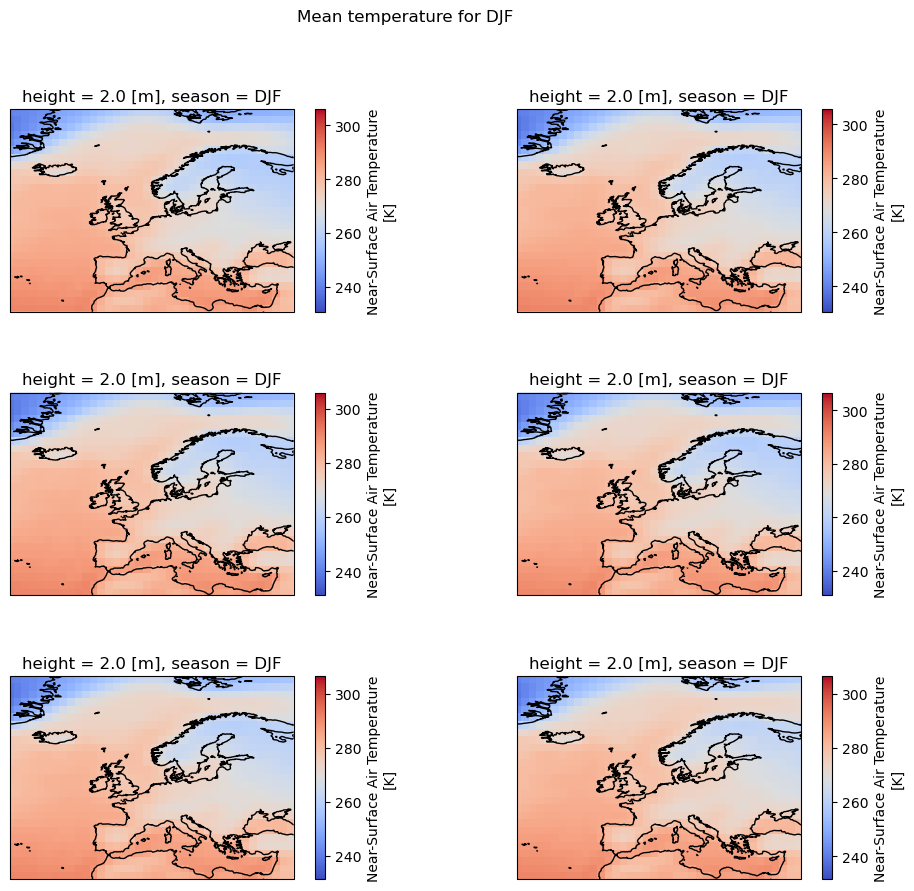

In [3]:
plot_seasonal_temperature("/work/uo1075/u301680/tas_data/data_reserve/tas_1850_2014.nc")

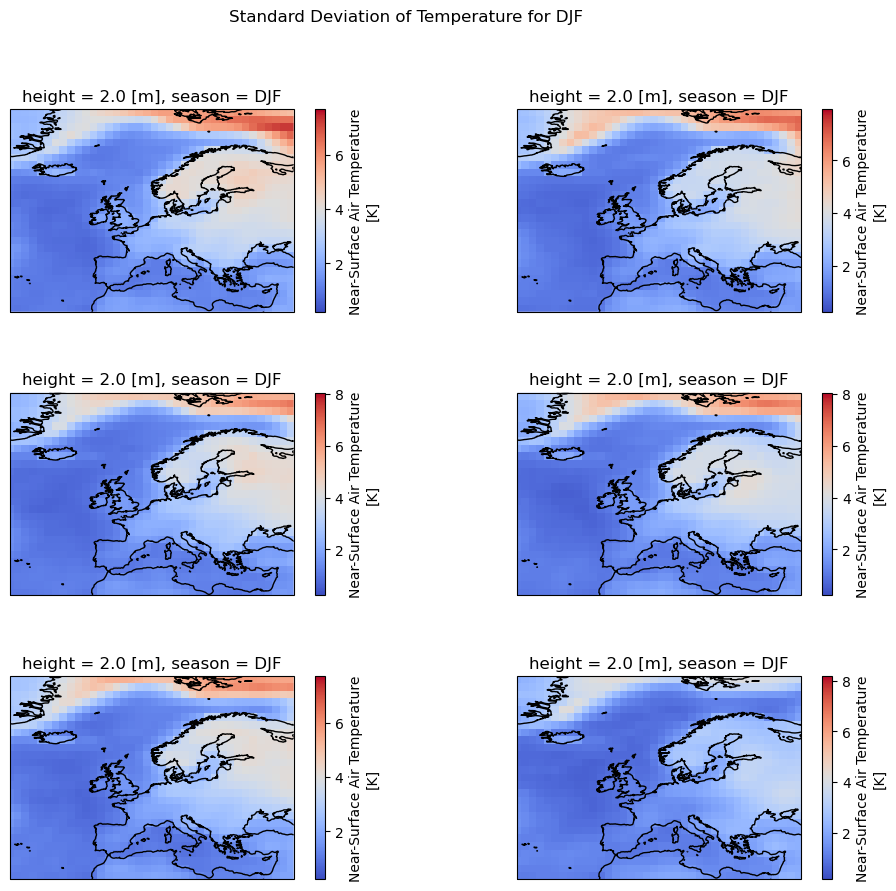

In [4]:
plot_seasonal_std("/work/uo1075/u301680/tas_data/data_reserve/tas_1850_2014.nc")

### Sesonal Mean Temperature Variation

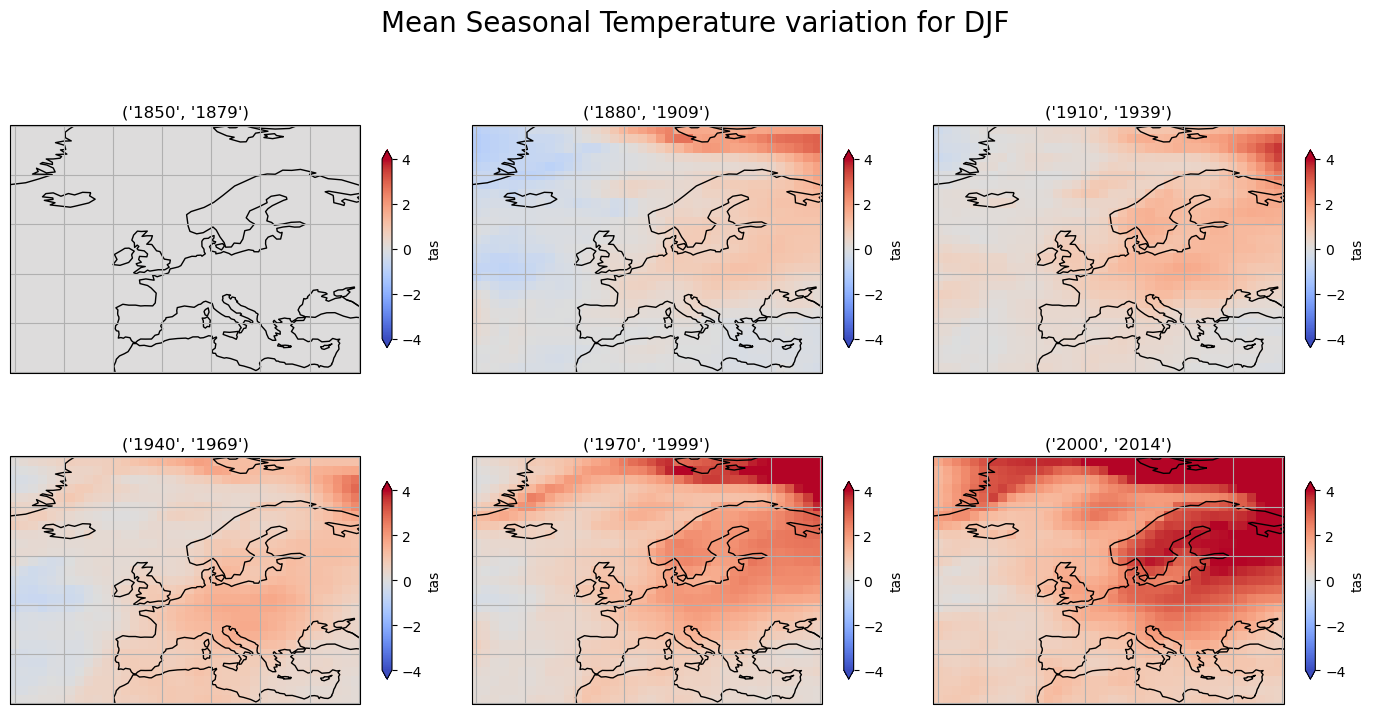

In [5]:
# Open the dataset after cutting the file which includes only  europe 
ds = xr.open_dataset("/work/uo1075/u301680/tas_data/data_reserve/tas_europe.nc")


# Select time periods
periods = [('1850', '1879'), ('1880', '1909'), ('1910', '1939'),
           ('1940', '1969'), ('1970', '1999'), ('2000', '2014')]

# Calculate seasonal means for each period
climatology = []
for period in periods:
    data = ds.sel(time=slice(*period))
    clim = data['tas'].groupby('time.season').mean('time').sel(season="DJF")
    climatology.append(clim)

# Calculate differences from the reference period
diffs = [clim -climatology[0] for clim in climatology]

# Create a Cartopy projection
projection = ccrs.PlateCarree()

# Create a figure and axes with Cartopy projection
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), subplot_kw={'projection': projection})

# # Add coastlines and gridlines to the axes
for ax in axes.flat:
    ax.coastlines()
    ax.gridlines()

# Plot the differences using subplots
for i, ax in enumerate(axes.flat):
    diff = diffs[i]
    cs = diff.plot(ax=ax, transform=projection, cmap='coolwarm', vmin=-4, vmax=4, cbar_kwargs={"shrink": 0.5},extend='both')
    ax.set_title(periods[i])
    fig.suptitle('Mean Seasonal Temperature variation for DJF', fontsize=20)

    
plt.tight_layout()
plt.savefig('mstvSAT')
plt.show()

# Linear Regression

In [6]:
# Importing libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.feature as cfeature

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# all tas data
all_tas = xr.open_dataset('/work/uo1075/u301680/tas_data/data_reserve/tas_1850_2014.nc')
all_tas = all_tas.sel(time = slice("1960", "2014"))

# tos data after regriding
all_tos = xr.open_dataset('/work/uo1075/u301680/tos_data/tos_regrid_1850_2014.nc')
all_tos = all_tos.sel(time = slice("1960", "2014"))

# Subset the SST data and SAT data
sst_subset = all_tos.sel(lat=slice(6, 40), lon=slice(288, 345))
# sst_subset = all_tos.sel(lat=slice(30, 60), lon=slice(300, 355))
sat_subset = all_tas.sel(lat=slice(30, 80), lon=slice(-30, 40))

# Calculate seasonal mean for autumn SST
seasonal_sst = sst_subset['tos'].resample(time="QS-DEC").mean()
autumn_sst = seasonal_sst.sel(time=seasonal_sst.time.dt.month==9)
# autumn_sst = autumn_sst.sel(time=autumn_sst.time.dt.month.isin([9, 10, 11]))

# Calculate seasonal mean for winter SAT
seasonal_sat = sat_subset['tas'].resample(time="QS-DEC").mean()
winter_sat = seasonal_sat.sel(time=seasonal_sat.time.dt.month==12)
#winter_sat = winter_sat.sel(time=winter_sat.time.dt.month.isin([12, 1, 2]))

# seasonal mean data
autumn_sst_values = np.nanmean(autumn_sst, axis=(1, 2))
winter_sat_values = np.nanmean(winter_sat[1:,:,:], axis=(1, 2))

Coefficients: 
 [1.6761618]
Mean squared error: 1.12
Coefficient of determination: 0.23


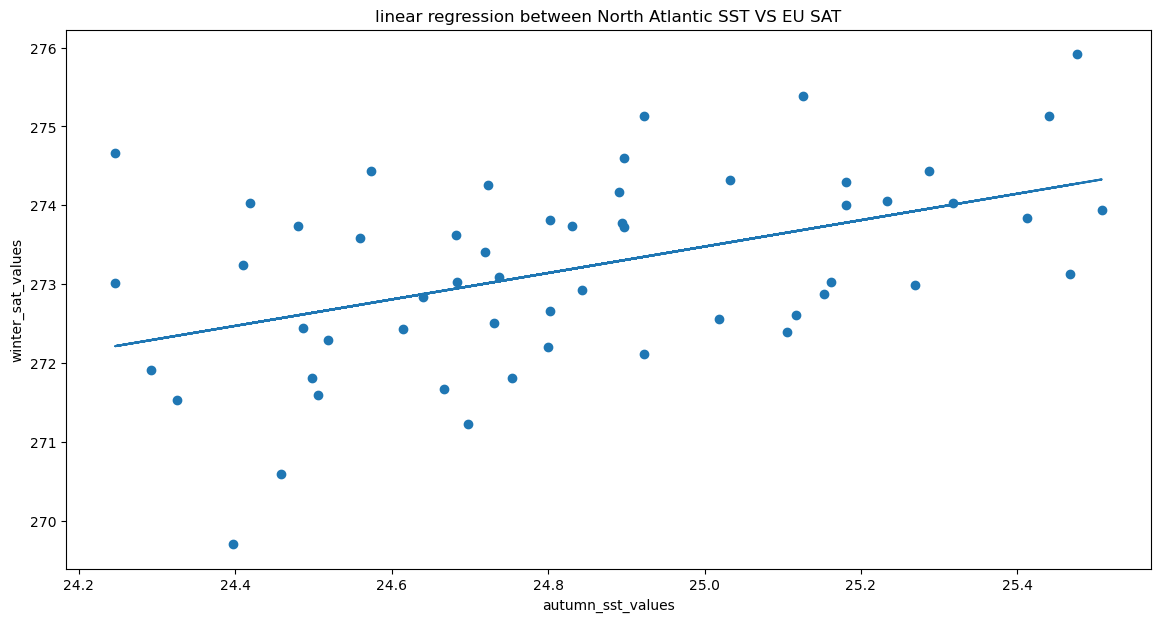

In [8]:
df = pd.DataFrame({'autumn_sst_values': autumn_sst_values, 'winter_sat_values': winter_sat_values})

# REMOVE OUTLIERS
# df = df[(df['winter_sat_values'] >= 270) & (df['winter_sat_values'] <= 275)]

# regr.fit(autumn_sst_values, winter_sat_values)
x = df.drop('winter_sat_values', axis=1)
y = df['winter_sat_values']

reg = LinearRegression()
reg.fit(x, y)

predictions = reg.predict(x)
m = reg.coef_
c = reg.intercept_
mse = mean_squared_error(y, reg.predict(x))
score = reg.score(x, y)

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, predictions))

plt.figure(figsize=(14, 7))
plt.scatter(x, y)
plt.plot(x, predictions)
plt.xlabel('autumn_sst_values')
plt.ylabel('winter_sat_values')
plt.title('linear regression between North Atlantic SST VS EU SAT')
plt.savefig("linear regression between NASST VS EUSAT")
plt.show()

# Correlation plots

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import xarray as xr
# import xskillscore as xs
import requests
import shapely.geometry as sgeom
from matplotlib.patches import Rectangle

# Season Calculation

In [11]:
member = 13
all_tas = xr.open_dataset(f"/work/uo1075/u301680/all_member/land/member_{member}_europe_tas.nc")
all_tos = xr.open_dataset(f"/work/uo1075/u301680/all_member/ocean/member_{member}_tos_regrid.nc")

# data between 1960 tp 2014
all_tas = all_tas.sel(time = slice("1960", "2014"))
all_tos = all_tos.sel(time = slice("1960", "2014"))

######################################################################################################
#####################################change the  lat lon #############################################
# Subset the data for Europe
sat_subset = all_tas.sel(lat=slice(30, 80), lon=slice(-30, 40))
# sat_subset = all_tas.sel(lat=slice(30, 70), lon=slice(-10, 40))
# sat_subset = all_tas.sel(lat=slice(45, 70), lon=slice(0, 30))
# sat_subset = all_tas.sel(lat=slice(45, 55), lon=slice(0, 20))

# Subset data for north atlantic
# sst_subset = all_tos.sel(lat=slice(30, 60), lon=slice(300, 355))
# sst_subset = all_tos.sel(lat=slice(8, 35), lon=slice(300, 343))
# sst_subset = all_tos.sel(lat=slice(12, 29), lon=slice(303, 332))
# sst_subset = all_tos.sel(lat=slice(30, 45), lon=slice(340, 350))
# sst_subset = all_tos.sel(lat=slice(8, 60), lon=slice(300, 355))
# sst_subset = all_tos.sel(lat=slice(0, 70), lon=slice(250, 360))
sst_subset = all_tos.sel(lat=slice(0, 70), lon=slice(265, 355))
##################################### change the lat lon #############################################
######################################################################################################

# Calculate seasonal mean for winter SAT
seasonal_sat = sat_subset['tas'].resample(time="QS-DEC").mean()
winter_sat = seasonal_sat.sel(time=seasonal_sat.time.dt.month==12)
winter_sat =winter_sat[1:]

# Calculate seasonal mean for autumn SST
seasonal_sst = sst_subset['tos'].resample(time="QS-DEC").mean()
autumn_sst = seasonal_sst.sel(time=seasonal_sst.time.dt.month==9)
autumn_sst = autumn_sst.fillna(autumn_sst.mean())

#Area averaged
autumn_sst_values = np.nanmean(autumn_sst, axis=(1, 2))
winter_sat_values = np.nanmean(winter_sat, axis=(1, 2))

In [12]:
all_tas

<xarray.Dataset>
Dimensions:    (time: 660, bnds: 2, lon: 38, lat: 27)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 -30.0 -28.12 -26.25 -24.38 ... 35.62 37.5 39.38
  * lat        (lat) float64 30.78 32.64 34.51 36.37 ... 73.68 75.54 77.41 79.27
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.2.4 (https://mpi...
    Conventions:            CF-1.7 CMIP-6.2
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r13i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ef223cd5-a2f3-441d-be1b-67ede1f08d38
    CDO:                    Climate Data Operators version 2.2.2 (https://mpi...

# Land

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


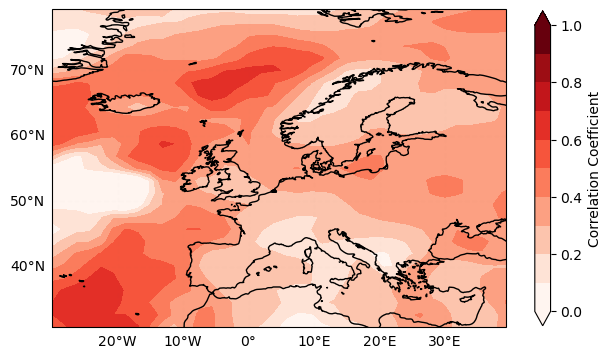

In [13]:
# Calculate the correlation between winter SAT and autumn SST for each grid point
corr = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

for i, lat in enumerate(winter_sat['lat']):
    for j, lon in enumerate(winter_sat['lon']):
        value = winter_sat.sel(lat=lat, lon=lon)
        correlation = np.corrcoef(autumn_sst_values, value)[0, 1]
        corr[i, j] = correlation
        
# Assuming you want contour levels from 0 to 0.9 in increments of 0.1
contour_levels = np.arange(0, 1.1, 0.1)

# Define the single color (red)
single_color = 'darkred'

# Generate a gradient of shades from low to high
num_levels = 10  # Adjust the number of levels as needed
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

######################################################################################################
########################################## change rectangular box #####################################

# Define the coordinates of the rectangular box
# lon1, lon2 = 0, 20
# lat1, lat2 = 45, 55
# Create a Rectangle instance
# rect = Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, linewidth=2, edgecolor='blue', facecolor='none', transform=ccrs.PlateCarree())

########################################## change rectangular box #####################################
######################################################################################################

# Plot the correlation values with the color gradient
c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr, colors=colors, transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)
plt.colorbar(c, label='Correlation Coefficient', shrink=0.70)

# # Add land masking
# land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray')
# ax.add_feature(land_mask)

# # Add ocean masking
# ocean_mask = cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='none', facecolor='white')
# ax.add_feature(ocean_mask)

# Add the rectangular box to the map
# ax.add_patch(rect)

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
# plt.title('Correlation: Each grid of winter 2mT vs Autumn sst values')
# plt.savefig("b")
plt.show()

# Ocean

/home/u/u301680/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/u/u301680/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


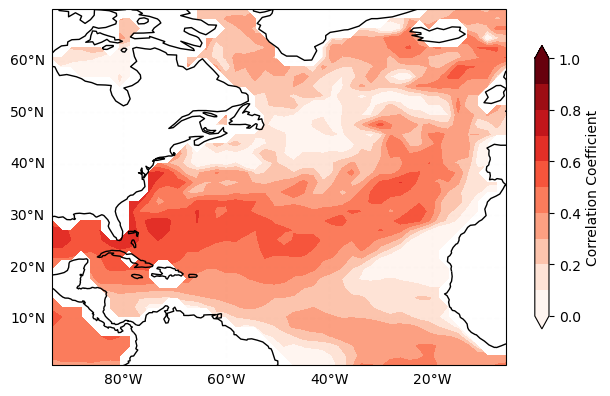

In [14]:
# Calculate the correlation between winter SAT and autumn SST for each grid point
corr1 = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

for i, lat in enumerate(autumn_sst['lat']):
    for j, lon in enumerate(autumn_sst['lon']):
        value = autumn_sst.sel(lat=lat, lon=lon)
        correlation = np.corrcoef(winter_sat_values, value)[0, 1]
        corr1[i, j] = correlation

# # Assuming you want contour levels from 0 to 0.9 in increments of 0.1
# contour_levels = np.arange(0, 0.7, 0.1)

# # Define the single color (red)
# single_color = 'darkred'

# # Generate a gradient of shades from low to high
# num_levels = 10  # Adjust the number of levels as needed
# colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

######################################################################################################
########################################## change rectangular box #####################################

# # Define the coordinates of the rectangular box
# lon1, lon2 = -57, -28
# lat1, lat2 = 12, 29

# lon1, lon2 = -10, -20
# lat1, lat2 = 30, 45

# Create a Rectangle instance
# rect = Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())

########################################## change rectangular box #####################################
######################################################################################################

# Plot the correlation values with the color gradient
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the correlation values with the color gradient
c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], corr1, colors=colors, transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)
plt.colorbar(c, label='Correlation Coefficient', shrink=0.63)

# Add the rectangular box to the map
# ax.add_patch(rect)

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
# plt.title('Correlation: Each grid of Autumn sst vs winter 2mT values')
# plt.savefig("a")
plt.show()

# Coorelation above 0.3

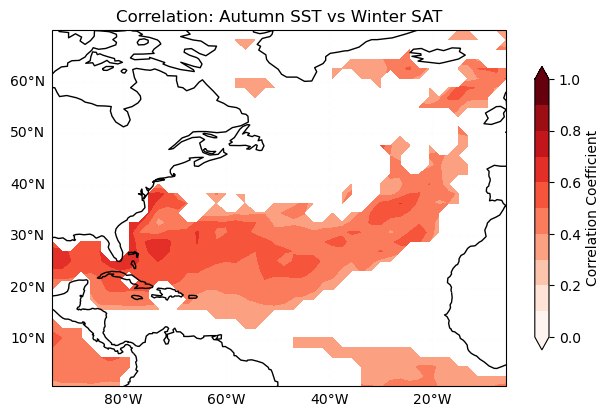

In [15]:
# Select regions with correlation above 0.3
threshold = 0.3
above_threshold_mask = corr1 > threshold


# Plot the correlation values with the color gradient
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the correlation values with the color gradient, using the mask
c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], np.ma.masked_where(~above_threshold_mask, corr1), colors=colors, transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)
plt.colorbar(c, label='Correlation Coefficient', shrink=0.63)

# Add the rectangular box to the map
# ax.add_patch(rect)

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
plt.title('Correlation: Autumn SST vs Winter SAT')
# plt.savefig("a")
plt.show()

In [16]:
# Extract autumn SST values where correlation is above 0.3
autumn_sst_above_threshold = autumn_sst.where(above_threshold_mask)
autumn_sst_valuesabove_threshold = np.nanmean(autumn_sst_above_threshold, axis=(1, 2))

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


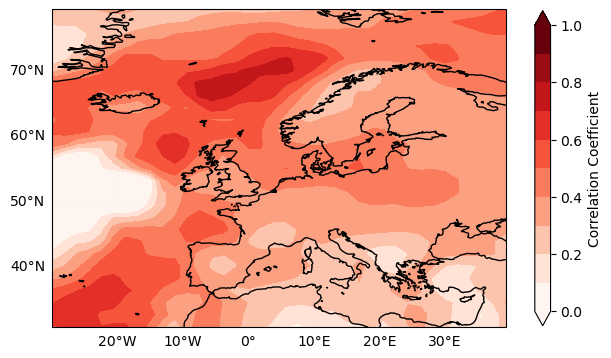

In [18]:
# Calculate the correlation between winter SAT and autumn SST for each grid point
corr = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

for i, lat in enumerate(winter_sat['lat']):
    for j, lon in enumerate(winter_sat['lon']):
        value = winter_sat.sel(lat=lat, lon=lon)
        correlation = np.corrcoef(autumn_sst_valuesabove_threshold, value)[0, 1]
        corr[i, j] = correlation


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the correlation values with the color gradient
c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr, colors=colors, transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)
plt.colorbar(c, label='Correlation Coefficient', shrink=0.70)

# # Add ocean masking
# ocean_mask = cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='none', facecolor='white')
# ax.add_feature(ocean_mask)

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add coastlines and gridlines
ax.coastlines()

plt.tight_layout()
# plt.title('Correlation: Each grid of winter 2mT vs Autumn sst values')
# plt.savefig("b")
plt.show()

# Selcting only the land area

In [19]:
corr

array([[0.59478393, 0.6026378 , 0.62765086, ..., 0.12032008, 0.16745026,
        0.23829863],
       [0.61903801, 0.63777257, 0.64083633, ..., 0.0906127 , 0.15613559,
        0.2555351 ],
       [0.59105623, 0.63549438, 0.63956555, ..., 0.15362518, 0.21073278,
        0.30764591],
       ...,
       [0.13909431, 0.14877474, 0.16777267, ..., 0.49691745, 0.50134322,
        0.50306594],
       [0.2213928 , 0.2209632 , 0.21788308, ..., 0.5155939 , 0.52236211,
        0.53305282],
       [0.22167627, 0.23465299, 0.25986776, ..., 0.47936717, 0.49372946,
        0.50655985]])